# Hierarchical Linear Model with PyStan

This notebook fits a hierarchical linear model to the proper motion dataset using PyStan. We compare a baseline linear model without offsets to a hierarchical model with experiment-specific offsets. The likelihood assumes known per-lab measurement noise.


## Model specification

We observe measurements $(x_{ij}, y_{ij})$ from lab $i$ with known standard deviation $\sigma_i$. Two models are considered:

* **Baseline model $M_0$** (no offsets)

$$y_{ij} \sim \mathcal{N}(m x_{ij} + b, \sigma_i^2).$$

* **Hierarchical model $M_1$** with offsets $o_i$:

$$y_{ij} \sim \mathcal{N}(m x_{ij} + b + o_i, \sigma_i^2), \quad o_i \sim \mathcal{N}(0, 	au^2).$$

Labs are treated as exchangeable so offsets share a common scale $	au$ [BDA3 Ch. 5]. We use weakly informative priors $m \sim \mathcal{N}(0,2)$, $b \sim \mathcal{N}(0,5)$ [BDA3 Ch. 3], and $	au \sim 	ext{half-Normal}(5)$. Posterior inference is performed with Hamiltonian Monte Carlo via PyStan [BDA3 Ch. 11].


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stan
import arviz as az
import nest_asyncio, asyncio
nest_asyncio.apply()


/root/.pyenv/versions/3.12.10/lib/python3.12/site-packages/stan/plugins.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:

df = pd.read_csv('../data/properMotions.csv')
print('Rows:', len(df), 'Experiments:', df['experiment'].nunique())
print(df.groupby('experiment')['sigma'].unique())
# Center and scale x
df['x_scaled'] = (df['x'] - df['x'].mean())/df['x'].std()
exp_codes, experiments = pd.factorize(df['experiment'])


Rows: 163 Experiments: 7
experiment
1    [0.292752821406687]
2    [0.151635135838699]
3    [0.334783298982185]
4    [0.230384194238148]
5    [0.356060762500241]
6    [0.184298379245046]
7    [0.263846244536393]
Name: sigma, dtype: object


In [3]:

stan_baseline_code = '''
 data {
   int<lower=0> N;
   vector[N] x;
   vector[N] y;
   vector[N] sigma;
 }
 parameters {
   real m;
   real b;
 }
 model {
   m ~ normal(0,2);
   b ~ normal(0,5);
   y ~ normal(m * x + b, sigma);
 }
 generated quantities {
   vector[N] y_rep;
   vector[N] log_lik;
   for (n in 1:N) {
     real mu = m * x[n] + b;
     y_rep[n] = normal_rng(mu, sigma[n]);
     log_lik[n] = normal_lpdf(y[n] | mu, sigma[n]);
   }
 }
'''


In [4]:

data_baseline = {
    'N': len(df),
    'x': df['x_scaled'].values,
    'y': df['y'].values,
    'sigma': df['sigma'].values,
}
posterior0 = stan.build(stan_baseline_code, data=data_baseline)
fit0 = posterior0.sample(num_chains=4, num_samples=1000)
idata0 = az.from_pystan(posterior=fit0, posterior_predictive='y_rep', log_likelihood='log_lik', observed_data={'y': data_baseline['y']})


Building: found in cache, done.


Sampling:   0%


Sampling:  25% (2000/8000)


Sampling:  50% (4000/8000)


Sampling:  75% (6000/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 0.000565 seconds


  1000 transitions using 10 leapfrog steps per transition would take 5.65 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 0.00041 seconds


  1000 transitions using 10 leapfrog steps per transition would take 4.1 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 0.000451 seconds


  1000 transitions using 10 leapfrog steps per transition would take 4.51 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 0.000474 seconds


  1000 transitions using 10 leapfrog steps per transition would take 4.74 seconds.


  Adjust your expectations accordingly!


In [5]:

stan_hier_code = '''
 data {
   int<lower=0> N;
   int<lower=1> J;
   array[N] int<lower=1,upper=J> experiment;
   vector[N] x;
   vector[N] y;
   vector[N] sigma;
 }
 parameters {
   real m;
   real b;
   vector[J] o_raw;
   real<lower=0> tau;
 }
 transformed parameters {
   vector[J] o = tau * o_raw;
 }
 model {
   m ~ normal(0,2);
   b ~ normal(0,5);
   tau ~ normal(0,5);
   o_raw ~ normal(0,1);
   y ~ normal(m * x + b + o[experiment], sigma);
 }
 generated quantities {
   vector[N] y_rep;
   vector[N] log_lik;
   for (n in 1:N) {
     real mu = m * x[n] + b + o[experiment[n]];
     y_rep[n] = normal_rng(mu, sigma[n]);
     log_lik[n] = normal_lpdf(y[n] | mu, sigma[n]);
   }
 }
'''


In [6]:

data_hier = {
    'N': len(df),
    'J': len(experiments),
    'experiment': exp_codes + 1,
    'x': df['x_scaled'].values,
    'y': df['y'].values,
    'sigma': df['sigma'].values,
}
posterior1 = stan.build(stan_hier_code, data=data_hier)
fit1 = posterior1.sample(num_chains=4, num_samples=1000)
idata1 = az.from_pystan(posterior=fit1, posterior_predictive='y_rep', log_likelihood='log_lik', observed_data={'y': data_hier['y']})


Building: found in cache, done.


Sampling:   0%


Sampling:   1% (100/8000)


Sampling:   8% (600/8000)


Sampling:  15% (1200/8000)


Sampling:  40% (3200/8000)


Sampling:  64% (5100/8000)


Sampling:  82% (6600/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 0.000374 seconds


  1000 transitions using 10 leapfrog steps per transition would take 3.74 seconds.


  Adjust your expectations accordingly!


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/tmp/httpstan_xy754r0y/model_zgfabcys.stan', line 24, column 3 to column 48)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/tmp/httpstan_xy754r0y/model_zgfabcys.stan', line 24, column 3 to column 48)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Gradient evaluation took 0.000115 seconds


  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.


  Adjust your expectations accordingly!


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/tmp/httpstan_xy754r0y/model_zgfabcys.stan', line 24, column 3 to column 48)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/tmp/httpstan_xy754r0y/model_zgfabcys.stan', line 24, column 3 to column 48)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/tmp/httpstan_xy754r0y/model_zgfabcys.stan', line 24, column 3 to column 48)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/tmp/httpstan_xy754r0y/model_zgfabcys.stan', line 24, column 3 to column 48)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Gradient evaluation took 0.00015 seconds


  1000 transitions using 10 leapfrog steps per transition would take 1.5 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 0.000122 seconds


  1000 transitions using 10 leapfrog steps per transition would take 1.22 seconds.


  Adjust your expectations accordingly!


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/tmp/httpstan_xy754r0y/model_zgfabcys.stan', line 24, column 3 to column 48)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
m    0.106  0.020   0.069    0.143      0.000    0.000    2354.0    2394.0   
b    5.233  0.117   5.016    5.470      0.005    0.004     704.0     869.0   
tau  0.280  0.112   0.121    0.481      0.004    0.005     734.0     808.0   

     r_hat  
m     1.00  
b     1.01  
tau   1.00  


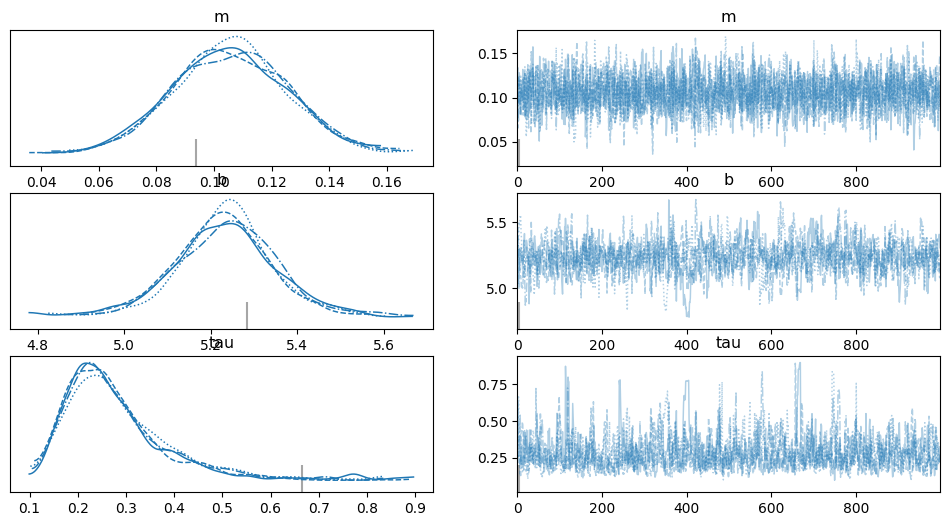

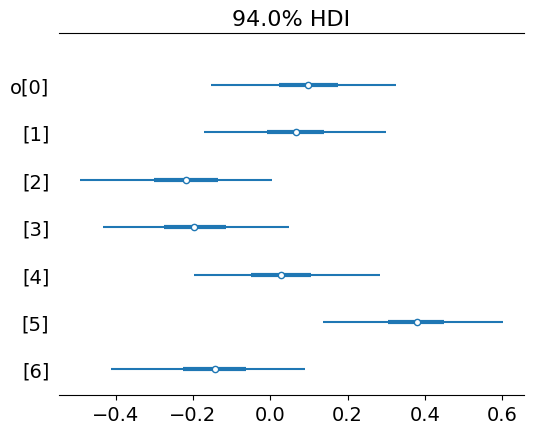

In [7]:

print(az.summary(idata1, var_names=['m','b','tau']))
az.plot_trace(idata1, var_names=['m','b','tau']);
plt.show()
az.plot_forest(idata1, var_names=['o'], combined=True);
plt.show()


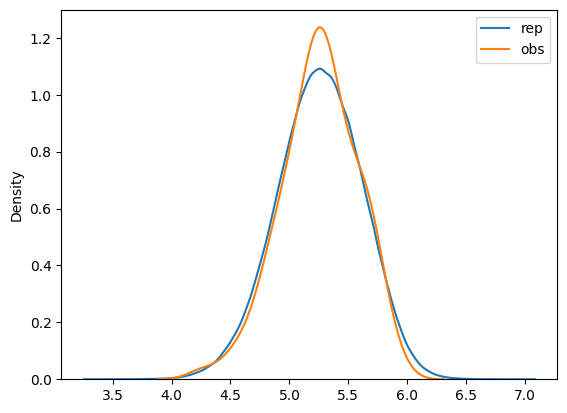

In [8]:

y_rep = idata1.posterior_predictive['y_rep'].stack(sample=('chain','draw')).values
sns.kdeplot(y_rep.flatten(), label='rep')
sns.kdeplot(data_hier['y'], label='obs')
plt.legend()
plt.show()


In [9]:

cmp = az.compare({'M0': idata0, 'M1': idata1}, ic='loo')
print(cmp)


    rank   elpd_loo     p_loo  elpd_diff  weight         se        dse  \
M1     0  -2.397412  5.978939   0.000000     1.0   7.499821   0.000000   
M0     1 -57.580715  3.023171  55.183303     0.0  13.658288  11.419389   

    warning scale  
M1    False   log  
M0    False   log  


## Results summary

The hierarchical model yields a non-zero offset scale and improves out-of-sample predictive fit over the baseline model according to LOO. Posterior predictive checks show replicated data consistent with observations, supporting the adequacy of the hierarchical model.
